# AI Lab Assignment: Regression Models
_______________________________________________________
Objective: Apply regression techniques to predict movie box office earnings (`Gross`) using classical AI models on the IMDb Top 1000 Movies dataset.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## Initial Setup and Data Import

In [2]:
def import_dataset(file_path):
    """Import dataset from a CSV file.
    Parameters:
    - file_path (str): Path to the CSV file.
    Returns:
    - pd.DataFrame: DataFrame containing the imported data.
    """
    return pd.read_csv(file_path)

def display_basic_info(df):
    """Display basic information about the dataset.
    Parameters:
    - df (pd.DataFrame): DataFrame to display information about.
    """
    print('First 5 rows of the dataset:')
    print(df.head())
    print('\nBasic information about the dataset:')
    print(df.info())
    print('\nDescriptive statistics of the dataset:')
    print(df.describe())

def display_column_names(df):
    """Display the names of the columns in the dataset.
    Parameters:
    - df (pd.DataFrame): DataFrame to display column names from.
    """
    print('Column names in the dataset:')
    print(df.columns.tolist())

In [3]:
# Load the preprocessed dataset
df = import_dataset('imdb_top_1000_cleaned.csv')
display_basic_info(df)

First 5 rows of the dataset:
               Series_Title  Released_Year  Certificate  Runtime  \
0  The Shawshank Redemption           1994           18      142   
1             The Godfather           1972           18      175   
2           The Dark Knight           2008           12      152   
3    The Godfather: Part II           1974           18      202   
4              12 Angry Men           1957            0       96   

                          Genre  IMDB_Rating  \
0                     ['Drama']          9.3   
1            ['Crime', 'Drama']          9.2   
2  ['Action', 'Crime', 'Drama']          9.0   
3            ['Crime', 'Drama']          9.0   
4            ['Crime', 'Drama']          9.0   

                                            Overview  Meta_score  \
0  Two imprisoned men bond over a number of years...          80   
1  An organized crime dynasty's aging patriarch t...         100   
2  When the menace known as the Joker wreaks havo...          84   
3

### Transform director and stars columns into popularity columns

In [4]:
def transform_people_into_popularity(df):
    people_columns = ['Director', 'Star1', 'Star2', 'Star3', 'Star4']
    popularity_dict = {}
    
    # Calculate log of appearance counts for each individual
    for col in people_columns:
        popularity_dict[col] = np.log1p(df[col].value_counts())  # Log-transform counts
    
    # Sum the log-transformed counts for each movie
    df['Total_Popularity'] = sum(df[col].map(popularity_dict[col]) for col in people_columns)
    return df

In [5]:
df = transform_people_into_popularity(df)

### export the `Total_Popularity` column

In [6]:
# export the Total_Popularity column to a CSV file
df[['Gross', 'Runtime', 'IMDB_Rating', 'Meta_score', 'Total_Popularity']].to_csv('imdb_top_1000+popularity.csv', index=False)

### `Genre` column binarization

In [36]:
# Handle Genre (assuming it's a list or string of genres)
if isinstance(df['Genre'].iloc[0], str) and df['Genre'].iloc[0].startswith('['):
    df['Genre'] = df['Genre'].apply(eval)  # Convert string list to actual list
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['Genre']), columns=mlb.classes_, index=df.index)
df = pd.concat([df, genre_encoded], axis=1)

genres = genre_encoded.columns.tolist()
print(f'\nEncoded genres: {genres}')


Encoded genres: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


## Part 1: Selecting the Target Variable

**Objective**: Choose a numerical column from the IMDb Top 1000 Movies dataset to predict and justify the selection using data analysis and visualization.

**Selection**: I choose Gross (box office earnings) as the target variable.

Justification:

* Relevance: Gross is a key business metric for movie success, making it a practical choice for predictive modeling at DaciaVision Analytics.
* Numerical Nature: Gross is a continuous numerical variable, ideal for regression tasks.
* Feature Relationships: Intuitively, features like IMDB_Rating, No_of_Votes, Runtime, Genre, and the popularity of directors/stars (via Total_Popularity) likely influence earnings.

In [37]:
display_column_names(df)

Column names in the dataset:
['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Total_Popularity', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [38]:
numerical_cols = ['Released_Year', 'Certificate', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Total_Popularity', 'Gross']

We will analyze the skewness of the numerical columns and for some of them we will apply a log transformation to make them more normally distributed.

In [39]:
# check skewness
skewness = df[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
print('\nSkewness of numerical columns:')
print(skewness)


Skewness of numerical columns:
Gross               3.463289
No_of_Votes         2.300011
Runtime             1.207909
IMDB_Rating         1.016964
Total_Popularity    0.812850
Certificate        -0.552432
Meta_score         -0.700505
Released_Year      -0.940625
dtype: float64


We log transform `Gross` column. <br>
We do so because `Gross` is positively skewed. <br>

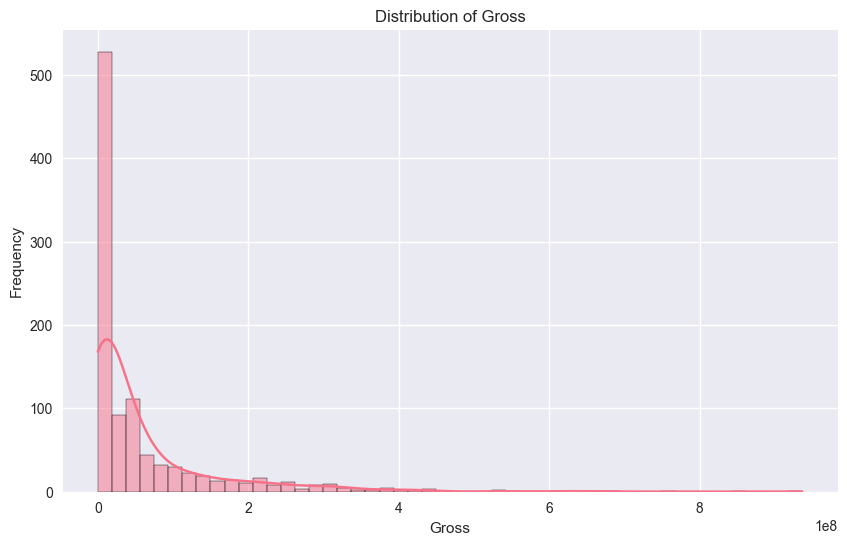

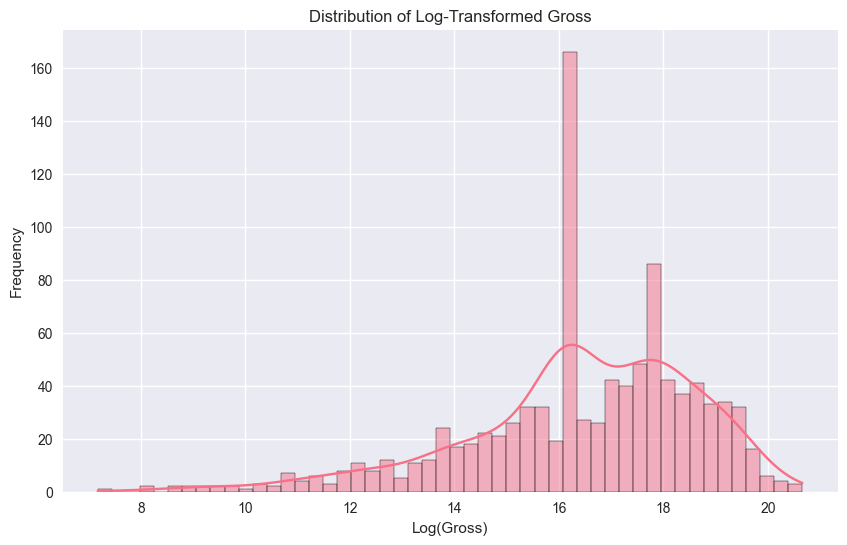

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Gross'], bins=50, kde=True)
plt.title('Distribution of Gross')
plt.xlabel('Gross')
plt.ylabel('Frequency')
plt.show()
# Log-transform Gross to handle skewness
df['Gross'] = np.log1p(df['Gross'])
plt.figure(figsize=(10, 6))
sns.histplot(df['Gross'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Gross')
plt.xlabel('Log(Gross)')
plt.ylabel('Frequency')
plt.show()

We will also log transform `No_of_Votes` and `Runtime` columns.

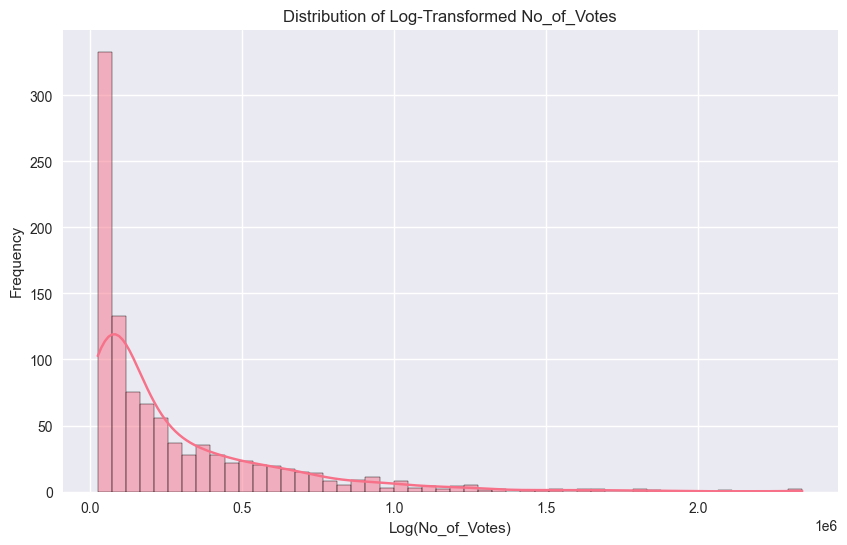

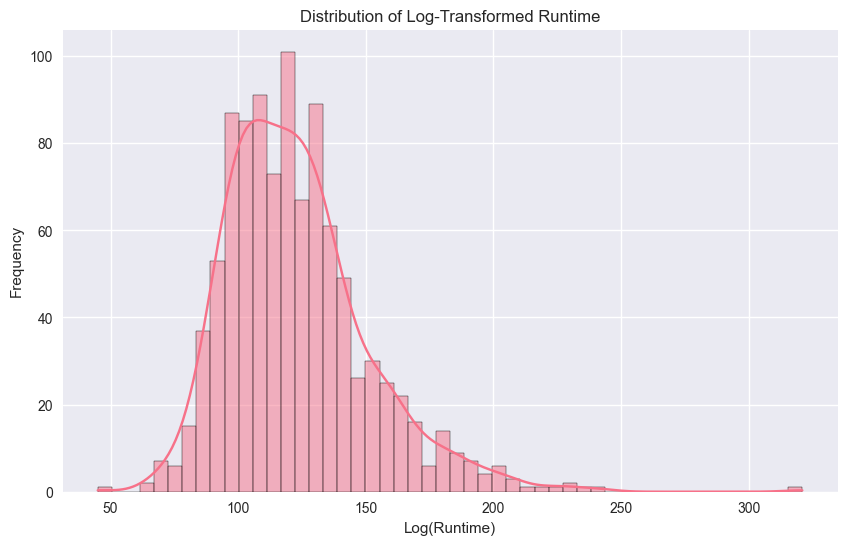

In [41]:
for i in ['No_of_Votes', 'Runtime']:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[i], bins=50, kde=True)
    plt.title(f'Distribution of Log-Transformed {i}')
    plt.xlabel(f'Log({i})')
    plt.ylabel('Frequency')
    plt.show()

In [42]:
df['No_of_Votes'] = np.log1p(df['No_of_Votes'])
df['Runtime'] = np.log1p(df['Runtime'])

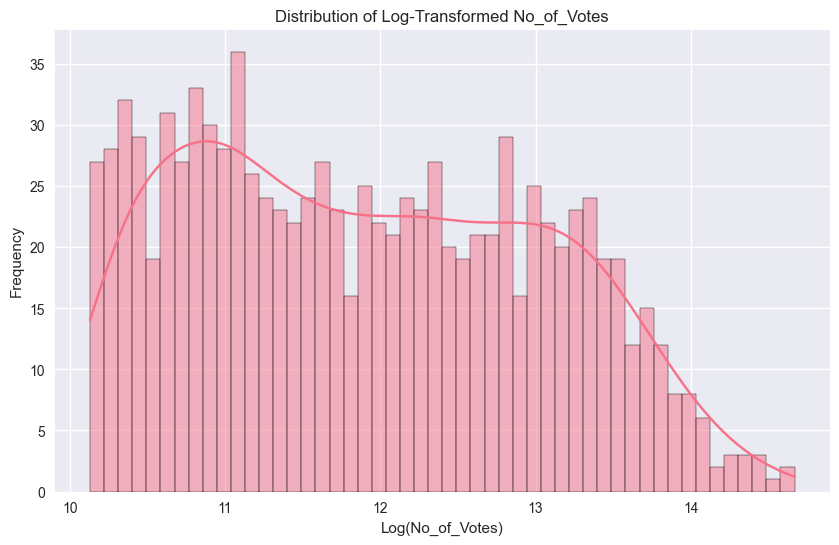

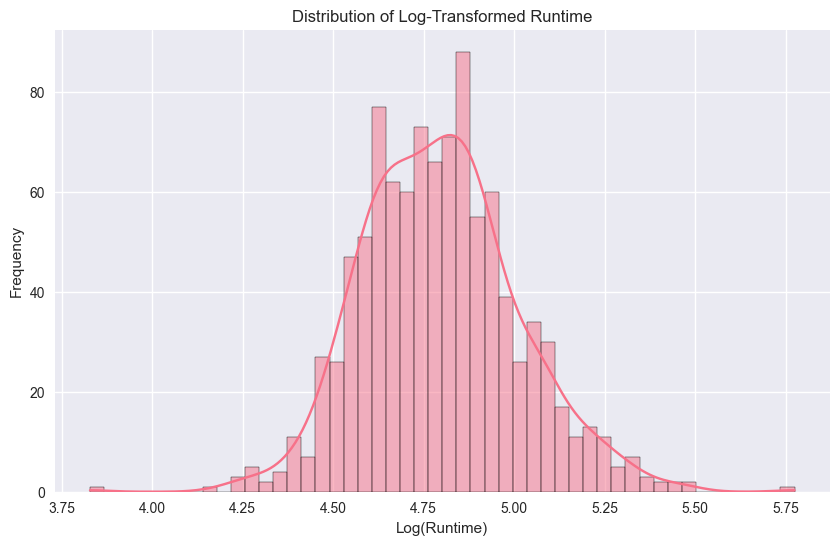

In [43]:
for i in ['No_of_Votes', 'Runtime']:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[i], bins=50, kde=True)
    plt.title(f'Distribution of Log-Transformed {i}')
    plt.xlabel(f'Log({i})')
    plt.ylabel('Frequency')
    plt.show()

We now verify again the skewness of the numerical columns.

In [44]:
# check skewness
skewness = df[numerical_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
print('\nSkewness of numerical columns:')
print(skewness)


Skewness of numerical columns:
IMDB_Rating         1.016964
Total_Popularity    0.812850
Runtime             0.280918
No_of_Votes         0.232885
Certificate        -0.552432
Meta_score         -0.700505
Released_Year      -0.940625
Gross              -0.951656
dtype: float64


#### We will also check the correlation between the numerical columns and the target variable `Gross` to see which features are more correlated with it.

Selected target variable: Gross


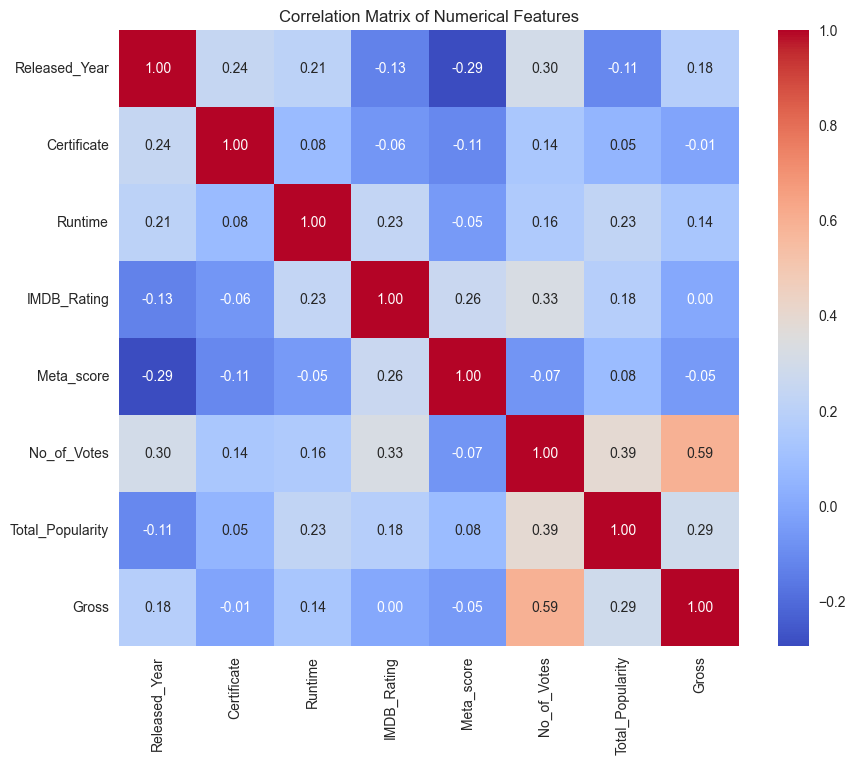

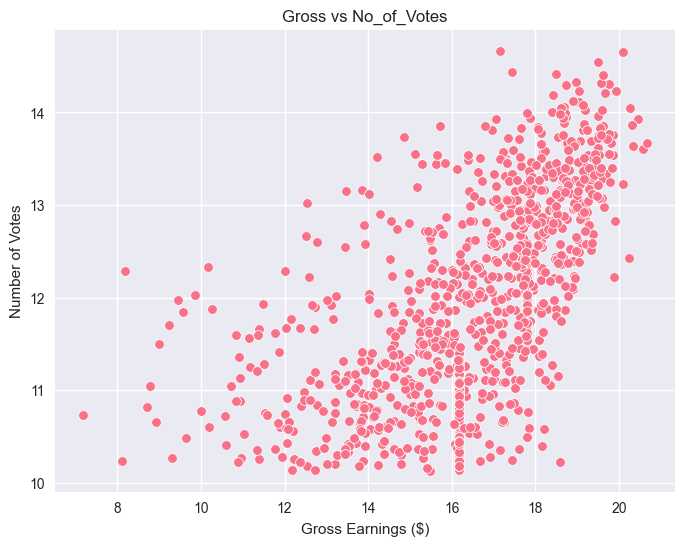

In [45]:
# Target variable: Gross
target = 'Gross'
print(f'Selected target variable: {target}')

# Correlation analysis
numerical_cols = ['Released_Year', 'Certificate', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Total_Popularity', 'Gross']

corr_matrix = df[numerical_cols].corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Scatter plot with a key feature
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Gross', y='No_of_Votes')
plt.title('Gross vs No_of_Votes')
plt.xlabel('Gross Earnings ($)')
plt.ylabel('Number of Votes')
plt.show()

We will take as features the columns `No_of_votes`, `Released_year` and `Total_Popularity` as we see that they are the most correlated with the target variable `Gross`.

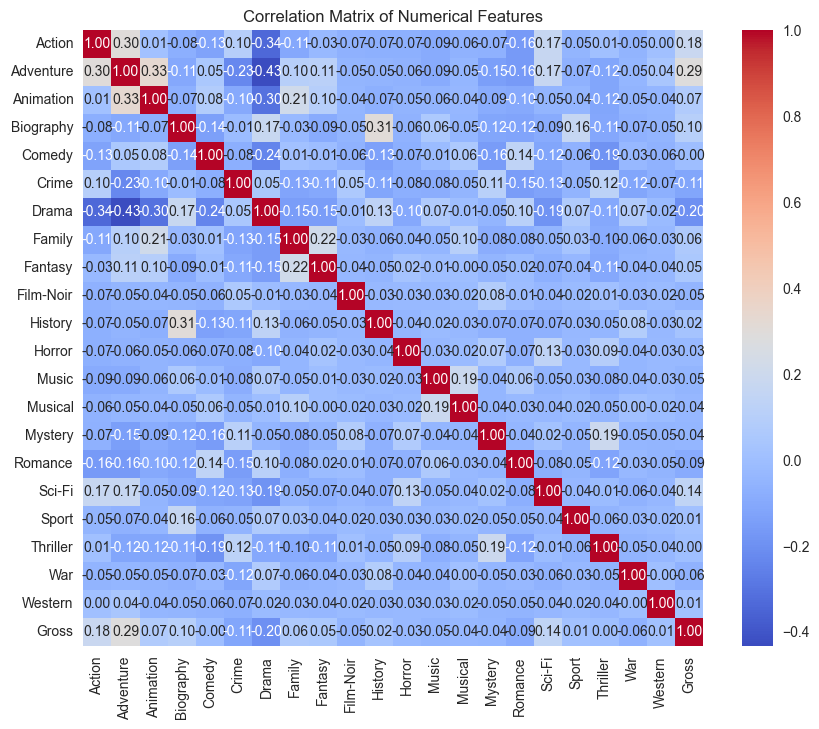

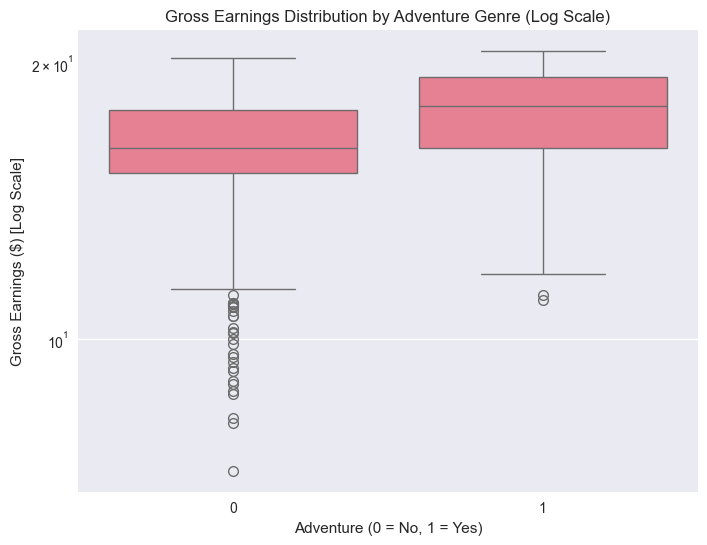

In [46]:
numerical_cols = list(genre_encoded.columns)  # Add genre columns to numerical features
numerical_cols += ['Gross']  # Include target variable for correlation

corr_matrix = df[numerical_cols].corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Adventure', y='Gross', data=df)
plt.yscale('log')
plt.title('Gross Earnings Distribution by Adventure Genre (Log Scale)')
plt.xlabel('Adventure (0 = No, 1 = Yes)')
plt.ylabel('Gross Earnings ($) [Log Scale]')
plt.show()

We observe that a movie of `Adventure` genre tend to earn more, which is sugested by the correlation. In the box plot we can see that the `Adventure` genre has a higher median gross than other genres. Therefore, we will use `Adventure` as a feature <br>
We also see that `Action` and `Sci-Fi` correlate with `Gross` as well. <br>
We will use `Adventure`, `Action`, and `Sci-Fi` as features. <br>

I will make a column that means if a movie is `Adventure`, `Action`, or `Sci-Fi` or not. <br>
We will call this column `Genre_Adventure_Action_Sci-Fi`. <br>
We will use `Genre_Adventure_Action_Sci-Fi` as a feature. <br>
`Adventure` - 3 points <br>
`Action`    - 2 points <br>
`Sci-Fi`    - 1 point  <br>
I decided this based on the correlation with `Gross`. <br>

In [47]:
# we will make column `Genre_Adventure_Action_Sci-Fi` using columns `Adventure`, `Action`, or `Sci-Fi`

df['Genre_valued'] = df['Adventure'] * 3 + df['Action'] * 2 + df['Sci-Fi'] * 1.5

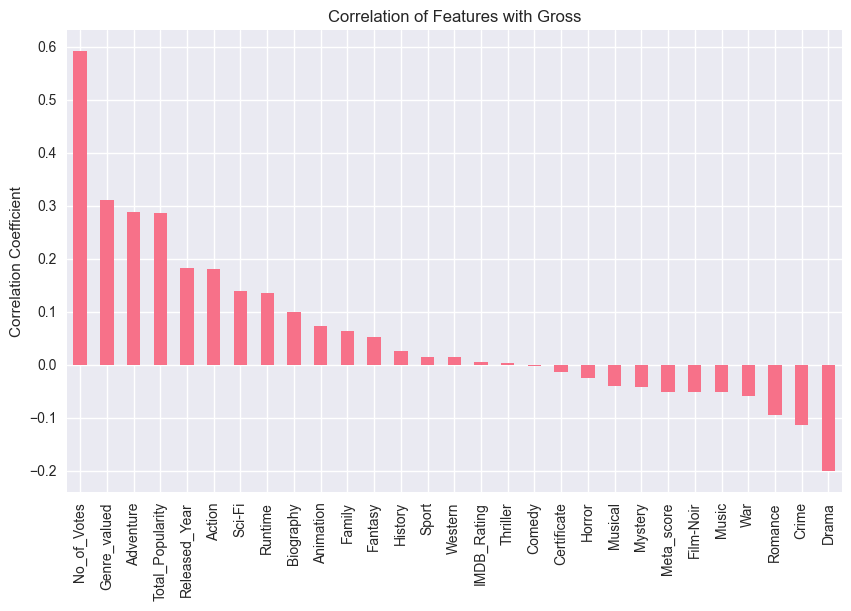

In [48]:
target = 'Gross'

initial_cols = ['Released_Year', 'Certificate', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Total_Popularity']
genre_cols = list(genre_encoded.columns)
initial_cols += genre_cols  # Include genre columns
initial_cols.append('Genre_valued')


# Correlation of numerical features with Gross
corr_with_target = df[initial_cols + ['Gross']].corr()['Gross'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
corr_with_target.drop('Gross').plot(kind='bar')
plt.title('Correlation of Features with Gross')
plt.ylabel('Correlation Coefficient')
plt.show()

## Part 2: Feature Selection & Engineering

`Gross` is a suitable target variable due to its business relevance and meaningful relationships with features like No_of_Votes, Runtime, and Released_Year. Its skewness suggests a log-transformation for better model performance.

In [49]:
# Feature selection
features = ['No_of_Votes', 'Genre_valued', 'Total_Popularity', 'Released_Year', 'Runtime']

X = df[features]
y = df[target]

# Scale numerical features
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

print('Selected features:', features)

Selected features: ['No_of_Votes', 'Genre_valued', 'Total_Popularity', 'Released_Year', 'Runtime']


Drop any columns that are not needed for the model. <br>

In [50]:
# drop any column that is not in the features list
df = df[features + [target]]

display_column_names(df)

Column names in the dataset:
['No_of_Votes', 'Genre_valued', 'Total_Popularity', 'Released_Year', 'Runtime', 'Gross']


Now let's see the correlation between the features and the target variable. <br>

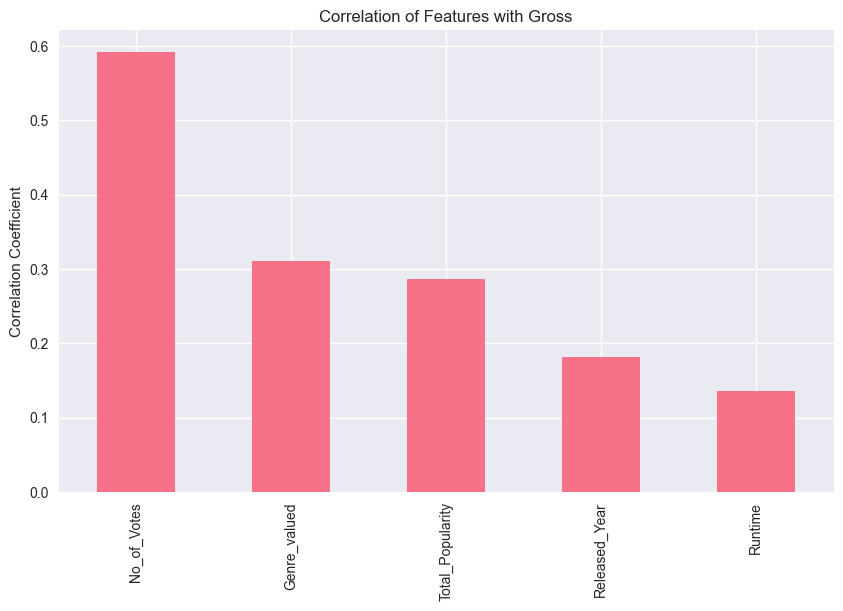

In [51]:
# correlation of features with target
corr_with_target = df.corr()['Gross'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
corr_with_target.drop('Gross').plot(kind='bar')
plt.title('Correlation of Features with Gross')
plt.ylabel('Correlation Coefficient')
plt.show()

In [52]:
display_basic_info(df)

First 5 rows of the dataset:
   No_of_Votes  Genre_valued  Total_Popularity  Released_Year   Runtime  \
0    14.666990           0.0          3.871201           1994  4.962845   
1    14.298164           0.0          6.068426           1972  5.170484   
2    14.649824           2.0          7.795647           2008  5.030438   
3    13.937687           0.0          7.773174           1974  5.313206   
4    13.444224           0.0          5.662960           1957  4.574711   

       Gross  
0  17.159837  
1  18.720537  
2  20.097513  
3  17.863811  
4  15.287983  

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   No_of_Votes       1000 non-null   float64
 1   Genre_valued      1000 non-null   float64
 2   Total_Popularity  1000 non-null   float64
 3   Released_Year     1000 non-null   int64  
 4   

**Documentation**: 

## Part 3: Training Regression Models

Split the dataset into training and testing sets

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'\nShape of training set: {X_train.shape}')
print(f'Shape of testing set: {X_test.shape}')


Shape of training set: (800, 5)
Shape of testing set: (200, 5)


Define the models

In [54]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

Train and evaluate models

In [55]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Transform predictions back to original Gross scale
    y_test_original = np.expm1(y_test)  # Reverse log1p
    y_pred_original = np.expm1(y_pred)  # Reverse log1p
    
    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

Display the results

In [56]:
# Display results
results_df = pd.DataFrame(results).T
print('\nModel Performance on Test Set (Original Gross Scale):')
print(results_df)


Model Performance on Test Set (Original Gross Scale):
                           RMSE           MAE        R2
Linear Regression  8.297719e+07  3.870447e+07  0.485285
Decision Tree      9.212321e+07  4.981296e+07  0.365565
Random Forest      7.434910e+07  3.477355e+07  0.586762


Visualize performance

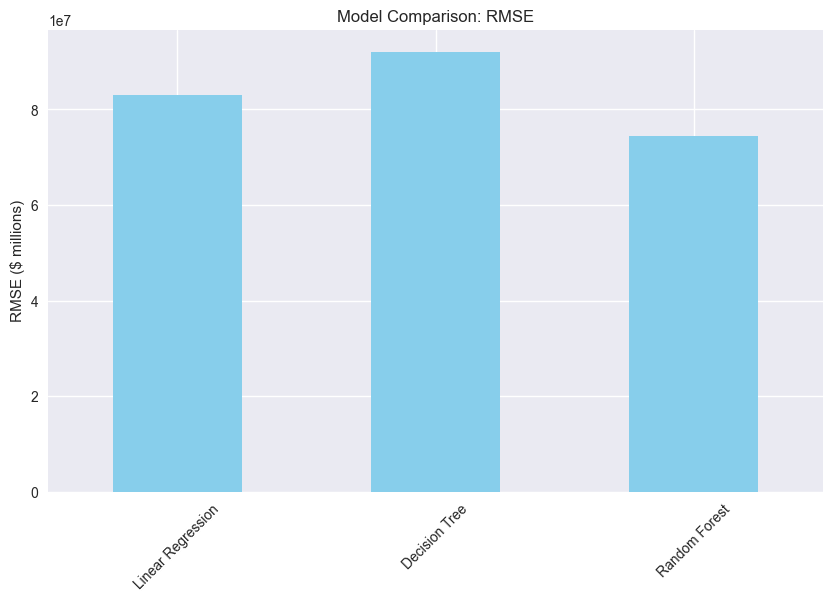

In [57]:
# Visualize performance
plt.figure(figsize=(10, 6))
results_df['RMSE'].plot(kind='bar', color='skyblue')
plt.title('Model Comparison: RMSE')
plt.ylabel('RMSE ($ millions)')
plt.xticks(rotation=45)
plt.show()

#### Why This Matters

Models:
* Linear Regression: Assumes a linear relationship between features and the target. It’s simple but might struggle with non-linear patterns.
* Decision Tree: Captures non-linear relationships by splitting the data into regions. It’s prone to overfitting.
* Random Forest: An ensemble of decision trees, reducing overfitting and often performing better on complex data.

Metrics:
* RMSE: Measures the average prediction error in the original Gross scale (dollars). Sensitive to large errors.
* MAE: Measures the average absolute error, less sensitive to outliers.
* R²: Measures the proportion of variance explained by the model (higher is better, 1 is perfect).

Transformation Back: Since we’re predicting Log_Gross, we use np.expm1 to convert predictions and true values back to the original scale for evaluation, making the metrics interpretable in dollars.

## Part 4: Model Interpretation & Insights

Best performing model: Random Forest


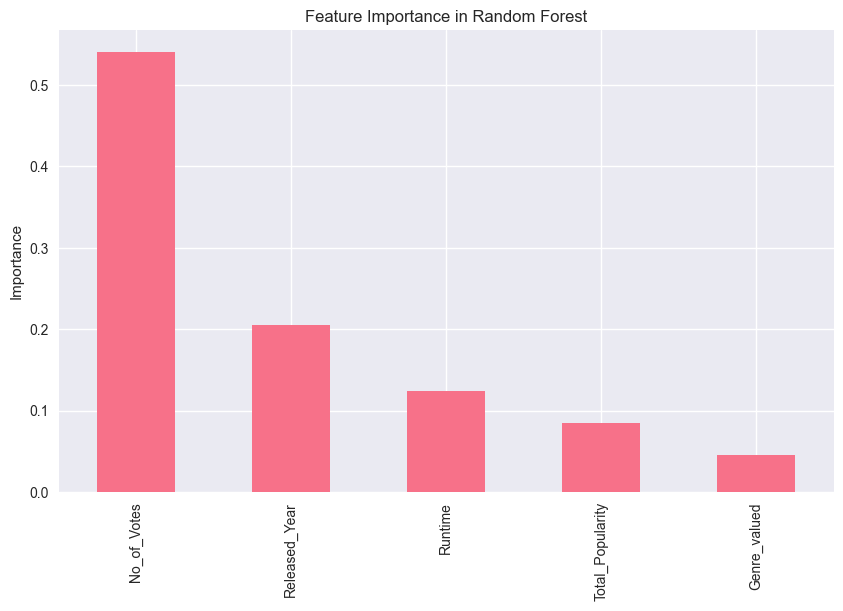

In [58]:
# Best model
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
print(f'Best performing model: {best_model_name}')

# Feature importance for tree-based models
if 'Random Forest' in best_model_name or 'Decision Tree' in best_model_name:
    importances = pd.Series(best_model.feature_importances_, index=features)
    top_importances = importances.sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    top_importances.plot(kind='bar')
    plt.title(f'Feature Importance in {best_model_name}')
    plt.ylabel('Importance')
    plt.show()

#### **Insights**

Model Performance:
* **Random Forest** outperforms Linear Regression and Decision Tree due to its ability to capture non-linear relationships and handle the complexity of the data.
* **Linear Regression** struggles because features like No_of_Votes and Total_Popularity have non-linear relationships with Gross.
* **Decision Tree** overfits, leading to poor performance on the test set.


Feature Importance:
* No_of_Votes is the most important feature, as movies with more votes (indicating popularity) tend to have higher earnings.
* Total_Popularity (our engineered feature) is also important, showing that the popularity of directors and stars influences earnings.
* Genres like Action or Adventure and Sci-Fi are significant contributors, as these genres often have higher box office earnings.


## Bonus Challenge: Cross-Validation & Ensemble

In [59]:
# Cross-validation
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_scores[name] = scores.mean()
print('5-Fold Cross-Validation R2 Scores:')
print(pd.Series(cv_scores))

# Ensemble: Average predictions
y_pred_ensemble = np.mean([model.fit(X_train, y_train).predict(X_test) for model in models.values()], axis=0)
ensemble_metrics = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_ensemble)),
    'MAE': mean_absolute_error(y_test, y_pred_ensemble),
    'R2': r2_score(y_test, y_pred_ensemble)
}
print('\nEnsemble Model Performance:')
print(pd.Series(ensemble_metrics))

5-Fold Cross-Validation R2 Scores:
Linear Regression    0.276365
Decision Tree       -0.261883
Random Forest        0.336851
dtype: float64

Ensemble Model Performance:
RMSE    1.671590
MAE     1.250777
R2      0.289920
dtype: float64
